In [1]:
""" Cualquier librería adicional que necesiteis durante el ejercicio, importadlo en esta sección """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Ejercicio 2

Este ejercicio pretende poner en práctica la habilidad de limpiar datos y visualizar plots en para crear finalmente modelos en __sklearn__.

El estudiante tendrá que repasar los comandos realizados en clase y lidiar con posibles errores durante el desarrollo. 

Para facilitar y agilizar el desarrollo, el estudiante tendrá que rellenar los huecos marcados como '_# codigo-alumno_'. No obstante, si además el estudiante necesita ejecutar código adicional, siempre podrá utilizar cualquier celda adicional. 

El estudiante tendrá siempre que introducir una semilla (seed) que generará acorde a su fecha de nacimiento (sin ser intrusivos en edad).

Finalmente, la entrega será un fichero .ipynb cambiando nombre y apellido al fichero.

In [2]:
""" El estudiante tendrá que utilizar la semilla proporcionada para todos los procesos aleatorios """

seed = 40

### Data cleansing

In [18]:
""" Leed el dataframe de sklearn llamado 'fetch_kddcup99' y almacenarlo en una variable llamada data """

from sklearn.datasets import fetch_kddcup99

data = fetch_kddcup99(as_frame=True)
pd_data = data.frame
pd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,1,0,0.11,0,0,0,0,0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,1,0,0.05,0,0,0,0,0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,1,0,0.03,0,0,0,0,0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,1,0,0.03,0,0,0,0,0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,1,0,0.02,0,0,0,0,0,b'normal.'


In [19]:
""" De entre todas las variables del dataframe, solo trabajaremos en 
    este ejercicio con las descritas en key_columns, por lo que tendréis que quitar el resto """

key_columns = ['duration', 'protocol_type', 'service', 'flag', 'logged_in', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'labels']

pd_data = pd_data[key_columns]
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
0,0,b'tcp',b'http',b'SF',1,8,8,0,9,0,b'normal.'
1,0,b'tcp',b'http',b'SF',1,8,8,0,19,0,b'normal.'
2,0,b'tcp',b'http',b'SF',1,8,8,0,29,0,b'normal.'
3,0,b'tcp',b'http',b'SF',1,6,6,0,39,0,b'normal.'
4,0,b'tcp',b'http',b'SF',1,6,6,0,49,0,b'normal.'


In [20]:
""" Comprobad que no haya nulos ni registros duplicados """
pd_data.isna().sum()

duration                    0
protocol_type               0
service                     0
flag                        0
logged_in                   0
count                       0
srv_count                   0
serror_rate                 0
dst_host_srv_count          0
dst_host_srv_serror_rate    0
labels                      0
dtype: int64

In [21]:
'Duplicados'
pd_data.duplicated().sum()

439856

In [22]:
'''Elimino duplicados'''
pd_data.drop_duplicates(inplace=True)
pd_data.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='labels', ylabel='count'>

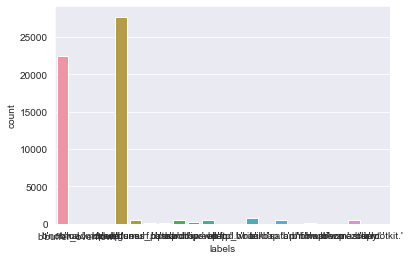

In [23]:
""" Mostrar un barplot para la variable objetivo (labels)"""

target = 'labels'
sns.countplot(x=target, data=pd_data)

In [24]:
""" Dado que hay dos etiquetas que se repiten con mayor frecuencia, 
    transformad la variable labels para que tenga un valor booleano que indique 
    si es la etiqueta más frecuente o la segunda más frecuente, 
    los demás registros los eliminaremos de este estudio """
pd_data.groupby('labels').size().sort_values(ascending=False)  #las etiquetas que mas se repiten son neptune y normal
pd_data['labels'] = pd_data['labels'].apply(lambda x: 1 if x in [b'neptune.', b'normal.'] else 0)

In [25]:
pd_data['labels'].value_counts()

1    50177
0     3988
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='count'>

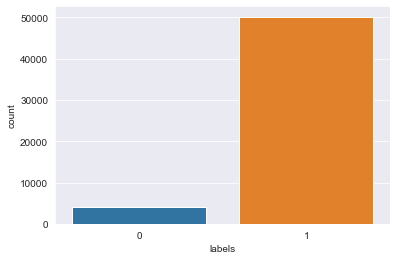

In [26]:
""" Volved a mostrar el barplot para la variable objetivo (labels) """
sns.countplot(x=target, data=pd_data)

In [27]:
""" Separaremos las variables categóricas de las numéricas """

num_cols = ['duration', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']
cat_cols = ['protocol_type', 'service', 'flag', 'logged_in']

pd_data[num_cols] = pd_data[num_cols].astype(float)

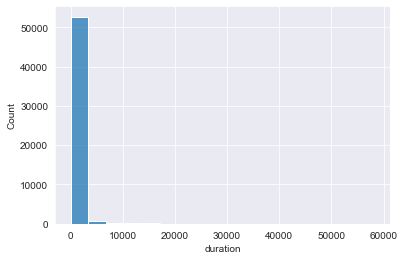

0.0        46256
1.0         1246
2.0          631
3.0          438
4.0          334
           ...  
2912.0         1
19745.0        1
21224.0        1
21795.0        1
9259.0         1
Name: duration, Length: 2495, dtype: int64


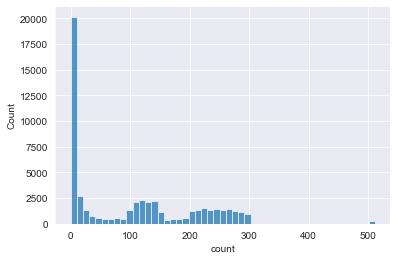

1.0      10711
2.0       3269
4.0       1287
3.0       1242
5.0        925
         ...  
392.0        1
304.0        1
476.0        1
325.0        1
394.0        1
Name: count, Length: 490, dtype: int64


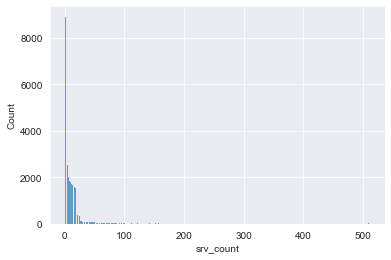

1.0      8900
2.0      5837
3.0      3145
4.0      2536
5.0      2161
         ... 
467.0       1
340.0       1
478.0       1
388.0       1
405.0       1
Name: srv_count, Length: 470, dtype: int64


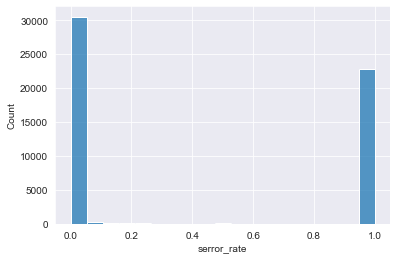

0.00    30257
1.00    22503
0.99      302
0.01       83
0.06       74
        ...  
0.44        1
0.89        1
0.35        1
0.87        1
0.80        1
Name: serror_rate, Length: 92, dtype: int64


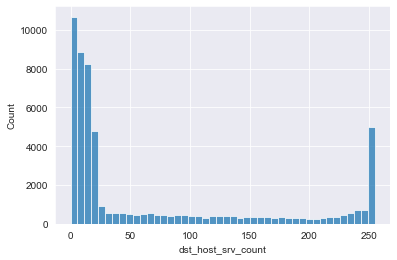

255.0    3796
1.0      3141
2.0      2717
3.0      1774
4.0      1534
         ... 
218.0      39
206.0      38
202.0      36
204.0      34
0.0         2
Name: dst_host_srv_count, Length: 256, dtype: int64


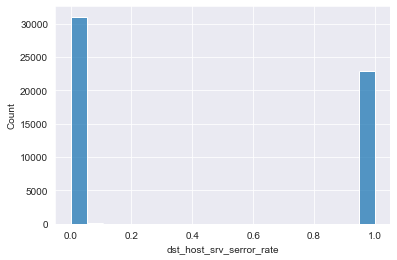

0.00    28314
1.00    22883
0.01     1932
0.02      521
0.03      143
        ...  
0.90        1
0.64        1
0.23        1
0.66        1
0.55        1
Name: dst_host_srv_serror_rate, Length: 72, dtype: int64


In [28]:
""" Mostrad un histograma por cada variable numérica """
for col in num_cols:
    sns.histplot(x=col, data=pd_data)
    plt.show()
    print(pd_data[col].value_counts())

In [29]:
""" Por la forma de los histogramas, podría ser un buen estudio convertir las variables
    numéricas a variables dummy, es lo que hareis en este apartado y, por tanto, pasarán 
    a ser categóricas todas las variables del dataframe. Esta parte será libre para el 
    estudiante. Deberá tomar la decisión que considere más apropiada para realizar esta 
    binarización """
# un buen valor de threshold puede ser la mediana de cada columna
medians = pd_data[num_cols].median().values
binar = Binarizer(medians)
data_transformed = pd.DataFrame(binar.fit_transform(pd_data[num_cols]), columns=num_cols)

In [ ]:
""" Mostrad un barplot por cada variable """

for col in num_cols:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    sns.histplot(x=col, data=pd_data)
    plt.title('Raw')
    plt.xlabel(col)
    plt.subplot(1,2,2)
    sns.countplot(x=col, data=data_transformed)
    plt.title('Transformed')
    plt.xlabel(col)

# Todas las variables están balanceadas excepto 'duration'

In [30]:
pd_data.drop(num_cols,1, inplace=True)

In [31]:
# Elimino las variables antiguas y añado las binarizadas
pd_result = pd.concat([pd_data, data_transformed], axis=1, join='inner', verify_integrity=True)

In [34]:
""" Transformad la variable service en una variable dummy que nos permitan identificar el servicio
    más frecuente frente al resto """

pd_result['service'] = pd_result['service'].apply(lambda x: 1 if x == b'private' else 0)
pd_result.groupby('service').size().sort_values(ascending=False)

service
0    30508
1    23657
dtype: int64

In [35]:
""" Transformad la variable flag en dos variables dummy que nos permitan identificar 3 tipos de flags, 
    los dos más comunes y el resto """

encoder = OneHotEncoder(sparse=False,drop='first')
pd_result.groupby('flag').size().sort_values(ascending=False)
pd_result['flag'] = pd_result['flag'].apply(lambda x: x if x in [b'SF',b'S0'] else b'Other')

flag_trasformed = pd.DataFrame(encoder.fit_transform(pd_result[['flag']]))
flag_trasformed.columns = encoder.get_feature_names(['flag'])
pd_final = pd.concat([pd_result.drop(['flag'],1), flag_trasformed], 1).reindex()

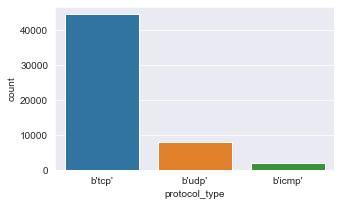

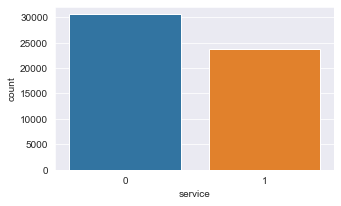

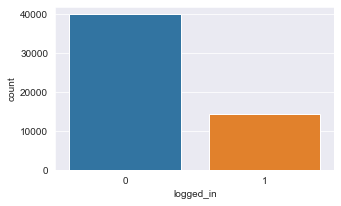

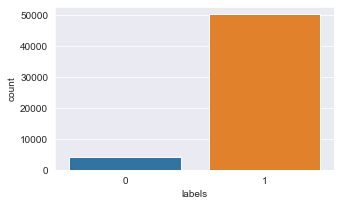

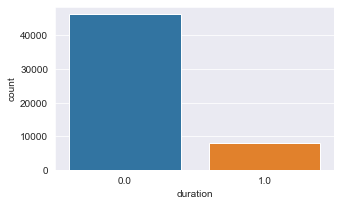

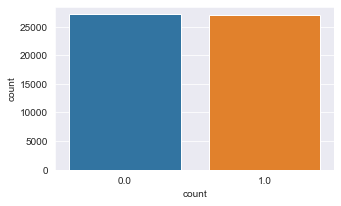

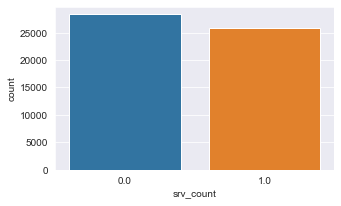

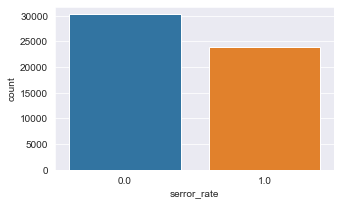

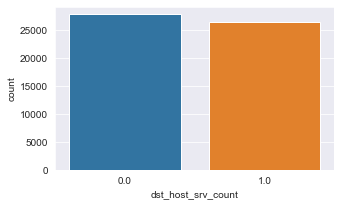

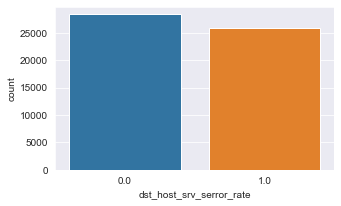

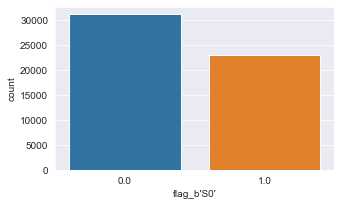

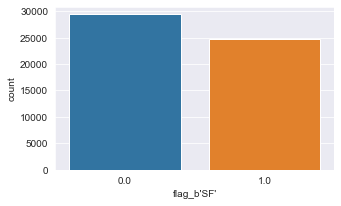

In [36]:
""" Volved a mostrad un barplot por cada variable """
for col in pd_final:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, data=pd_final)
    plt.xlabel(col)

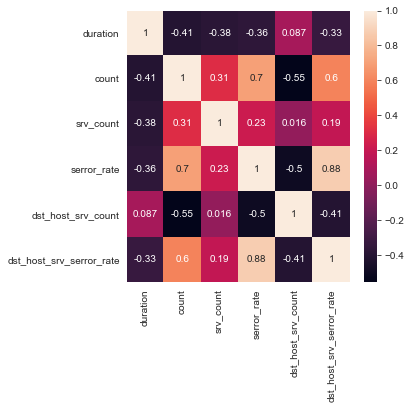

In [37]:
""" Mostrad un plot de correlaciones entre variables numéricas """

plt.figure(figsize=(5,5))
sns.heatmap(data_transformed.corr(), annot=True)
plt.show()

#Las correlaciones más altas son de count con dst_host_srv_count y serror_rate con dst_host_srv_count

### Model evaluation

In [38]:
""" Realizad una evaluación de, al menos, cinco modelos de machine learning con
    la técnica de validación cruzada más acertada (10 splits). Además, se pide
    incorporar, al menos, una técnica de selección previa de las 1, 2 o 3 features que
    mejores resultados ofrezca (Nota, tendreis que usar OneHotEncoder para las variables 
    que tengan strings) """

X = pd_final.drop(target, axis=1) 
y = pd_final[target]

In [39]:
# OneHotEncoder para la columna de protocol_type
encoder_prot = OneHotEncoder(sparse=False)
protocol_tr = pd.DataFrame(encoder_prot.fit_transform(X[['protocol_type']]))
protocol_tr.columns = encoder_prot.get_feature_names(['protocol_type'])
X_tr = pd.concat([X.drop(['protocol_type'], 1),
          protocol_tr], axis=1).reindex()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size=0.3, random_state=40)

**Para KBest:**   
La variable que más importancia tiene es la columna que representa el tipo icmp de la columna protocol_type, tiene una puntuación seis veces superior a la de la siguiente variable. Por tanto, es normal que al incluir una o dos variables más al modelo la accuracy del mismo no debería tener demasiada variación

In [221]:
algorithm = RandomForestClassifier(random_state=40)
for k in range(1, 4):
    sel_KBest = SelectKBest(score_func=chi2, k=k)
    sel_KBest.fit(X_train, y_train)
results = pd.DataFrame(zip(X_train.columns, sel_KBest.pvalues_, sel_KBest.scores_), columns=['feature', 'p_val', 'score'])
results.sort_values('score', ascending=False, inplace=True)
results

,feature,p_val,score
10,protocol_type_b'icmp',0.000000e+00,6200.782668
8,flag_b'S0',6.143738e-236,1075.755082
7,dst_host_srv_serror_rate,2.858720e-191,870.264087
9,flag_b'SF',1.148098e-177,807.690679
5,serror_rate,1.833629e-126,572.234239
3,count,1.473274e-78,352.107142
11,protocol_type_b'tcp',1.823042e-70,314.950601
6,dst_host_srv_count,1.147397e-63,283.744087
0,service,6.183209e-60,266.621691
4,srv_count,1.473408e-17,72.747553


**RFE**

              precision    recall  f1-score   support

           0       0.68      0.32      0.44      1167
           1       0.95      0.99      0.97     15083

    accuracy                           0.94     16250
   macro avg       0.81      0.66      0.70     16250
weighted avg       0.93      0.94      0.93     16250

              precision    recall  f1-score   support

           0       1.00      0.25      0.39      1167
           1       0.94      1.00      0.97     15083

    accuracy                           0.95     16250
   macro avg       0.97      0.62      0.68     16250
weighted avg       0.95      0.95      0.93     16250

              precision    recall  f1-score   support

           0       1.00      0.25      0.39      1167
           1       0.94      1.00      0.97     15083

    accuracy                           0.95     16250
   macro avg       0.97      0.62      0.68     16250
weighted avg       0.95      0.95      0.93     16250



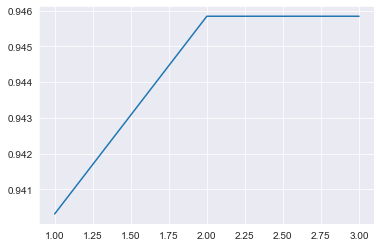

In [210]:
algorithm = RandomForestClassifier(random_state=40)
results_RFE = []
for k in range(1, 4):
    sel_RFE = RFE(estimator=algorithm, n_features_to_select=k)
    model2 = make_pipeline(sel_RFE, algorithm)
    model2.fit(X_train, y_train)
    result_RFE = model2.score(X_test, y_test)
    results_RFE.append(result_RFE)
    y_pred = model2.predict(X_test)
    print(classification_report(y_test, y_pred))
plt.plot(range(1,4), results_RFE)

[[  595   572]
 [   12 15071]]
[[  594   573]
 [   10 15073]]
[[  594   573]
 [   10 15073]]


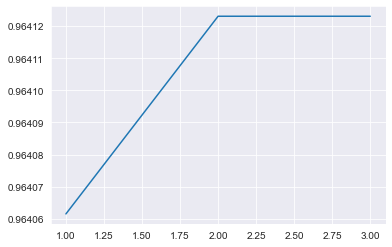

In [212]:
results_PCA = []
for k in range(1,4):
    sel_PCA = PCA(n_components=k)
    model3 = make_pipeline(sel_PCA, algorithm)
    model3.fit(X_train, y_train)
    result_PCA = model3.score(X_test, y_test)
    y_pred = model3.predict(X_test)
    results_PCA.append(result_PCA)
    print(confusion_matrix(y_test, y_pred))
plt.plot(range(1,4), results_PCA)

De todas las técnicas de selección de variables, el mejor resultado se obtiene para 2 o 3 componentes con PCA

In [ ]:
models = [
    LogisticRegression(random_state=40), 
    LinearDiscriminantAnalysis(), 
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    SVC()
]

## Modelo final con Cross Validation

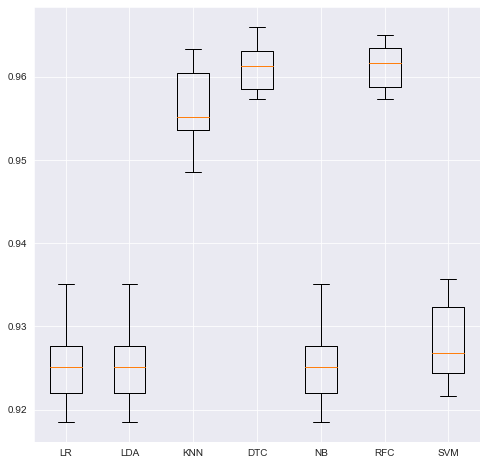

In [222]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier()))
models.append(('SVM', SVC()))

# para 2 componentes con PCA
results = []
names = []
sel_PCA = PCA(n_components=2)
for name, model in models:
    pipeline = make_pipeline(sel_PCA, model)

    kf = KFold(n_splits=10, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline,X_train,y_train,cv=kf)             
    names.append(name)
    results.append(cv_results)

plt.figure(figsize=(8,8))
plt.boxplot(results)
plt.xticks(range(1,len(names)+1), names)
plt.show()

El mejor resultado en media se obtiene con DecisionTreeClassifier() y RanfomForestClassifier()

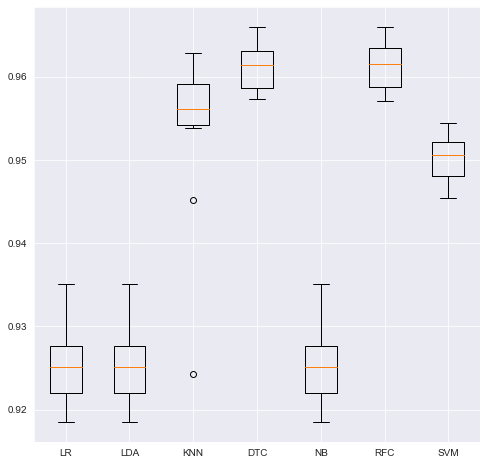

In [223]:
# para k=3 con PCA
results = []
names = []
sel_PCA = PCA(n_components=3)
for name, model in models:
    pipeline = make_pipeline(sel_PCA, model)

    kf = KFold(n_splits=10, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline,X_train,y_train,cv=kf)             
    names.append(name)
    results.append(cv_results)

plt.figure(figsize=(8,8))
plt.boxplot(results)
plt.xticks(range(1,len(names)+1), names)
plt.show()

Como se puede apreciar los algoritmos de SVM, y KNN mejoran con 3 componentes con respecto a 2, pero RandomForestClassifier y DecisionTreeClassifier siguen siendo los dos algoritmos con mejor accuracy. Usaré esos dos modelos para calcular la accuracy en test y ver cuál es mejor

In [224]:
sel_PCA = PCA(n_components=2)

In [225]:
pipeline_RFC = make_pipeline(sel_PCA, RandomForestClassifier())
pipeline_RFC.fit(X_train, y_train)
print(pipeline_RFC.score(X_test, y_test))

0.964123076923077


In [226]:
pipeline_DTC = make_pipeline(sel_PCA, DecisionTreeClassifier())
pipeline_DTC.fit(X_train, y_train)
print(pipeline_DTC.score(X_test, y_test))

0.9639384615384615


Se obtiene mejor resultado en el conjunto de test para el RandomForestClassifier así qeu este será el algoritmo escogido. 
RandomForestClassifier con la técnica de selección de variables PCA con 2 componentes.